## Notebook Content

- Exploratory Data Analysis after adding our data generation to the fliker photos data
  - Reading Dataset
  - Cleaning Dataset
- Natural Language Processing
  - Text Cleaning
  - Performed text cleaning
  - Removed digits from texts.
  - Made all text lowercase.
  - Removed all punctuations.
  - 'startseq' was added at the beginning of each caption
  - 'endseq' was added at the end of each caption
- Deep Learning
  - Traditinal Neural Network
  - Recurrent Neural Network
  - Transfer Learning
  - Word Embeddings

### Importing needed libraries

In [ ]:
!pip install deep-translator

     |████████████████████████████████| 97 kB 3.5 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.0.3 which is incompatible.


In [ ]:
! pip install pygame

     |████████████████████████████████| 21.8 MB 1.2 MB/s 


In [ ]:
!pip install gTTs

In [ ]:
!pip install Keras

In [ ]:
!pip install tensorflow

In [1]:
import pandas as pd
import os
# from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import numpy as np
from PIL import Image
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.preprocessing import image
from keras.layers import LSTM, Embedding, Dropout, Dense
from keras.layers.merge import add
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
import matplotlib.pyplot as plt
import keras
from gensim.models import Word2Vec
from keras import Input, layers
import pickle
from deep_translator import GoogleTranslator
from pygame import mixer
from gtts import gTTS

pygame 2.1.2 (SDL 2.0.16, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Methods Used

#### Text Cleaning
- Removed digits from texts
- Removed all punctuations.
- Made all text lowercase.
- Adding 'startseq' , 'endseq' at the beginning and the end of each captions

In [2]:
def clean_method(text):
    """This method is to clean text on passed parameter"""
    if type(text) is not str:
        return ''
    text = text.lower() 
    text = text.replace('\\n', ' ').replace('\\r', ' ').replace('\\t', ' ')
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    text = re.sub('[^a-z]+', ' ', text)
    text = 'startseq ' + text + ' endseq'
    return ' '.join(text.split())

#### Prepare images before inserting it to model

In [3]:
def preprocess(image_path):
    # Convert all the images to size 299 x 299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [4]:
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for index, row in descriptions.iterrows():
            n+=1
            # retrieve the photo feature
            photo = photos[index]
            list_of_captions = [row['Caption_1'], row['Caption_2'], row['Caption_3'], row['Caption_4'], row['Caption_5']]
            for desc in list_of_captions:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = np_utils.to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n == num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

#### For Testing the Final Model

In [7]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = h_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

#### For getting the maximum length of captions

In [8]:
def get_max_length(lines):
    return max(len(d.split()) for d in lines)

#### For getting the caption in arabic

In [9]:
def ar_caption(img_path):
    dr_image = encode(img_path)
    image_re = dr_image.reshape((1,2048))
    x = plt.imread(img_path)
    plt.imshow(x)
    plt.show()
    translated = GoogleTranslator(source='auto', target='ar').translate(greedySearch(image_re))
    return ("الوصف: " + translated), translated

#### For getting the caption in english

In [10]:
def en_caption(img_path):
    dr_image = encode(img_path)
    image_re = dr_image.reshape((1,2048))
    x = plt.imread(img_path)
    plt.imshow(x)
    plt.show()
    result = greedySearch(image_re)
    return ("Caption: " + result), result

#### For speech caption in arabic

In [11]:
def ar_speech(img_path):
    tmp, mytext = ar_caption(img_path)
    print(tmp)
    language = 'ar'
    myobj = gTTS(text=mytext, lang=language, slow=False)
    file_name = img_path[img_path.rfind("/")+1:img_path.rfind(".")] + "_ar_.mp3"
    myobj.save(file_name)
    mixer.init()
    mixer.music.load("./" + file_name)
    mixer.music.play()

#### For speech caption in english

In [12]:
def en_speech(img_path):
    tmp, mytext = en_caption(img_path)
    print(tmp)
    language = 'en'
    myobj = gTTS(text=mytext, lang=language, slow=False)
    file_name = img_path[img_path.rfind("/")+1:img_path.rfind(".")] + "_en_.mp3"
    myobj.save(file_name)
    mixer.init()
    mixer.music.load("./" + file_name)
    mixer.music.play()

### Exploratory Data Analysis
- Reading Data
- Cleaning Data

### Reading 2 Datasets

In [13]:
data_30k= "/content/drive/MyDrive/image.tokenex.txt"
dir_Flickr_jpg = "/content/drive/MyDrive/photosof_dataset"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in data30k: {}".format(len(jpgs)))

The number of jpg flies in data30k: 8137


In [14]:
data_30k

'/content/drive/MyDrive/image.tokenex.txt'

In [15]:
def load_csv(directory):
    desc=dict()
    text = pd.read_csv(directory, delimiter='|',header=None,names=["picname","caption"])
    text = text.iloc[1:,:]
    df_new = text[text.iloc[:,2].notnull()]
    print(df_new.iloc[:5,:])
    return df_new  

In [16]:
from collections import Counter 
file = open(data_30k,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["picname","index","caption"])


uni_filenames = np.unique(df_txt.picname.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.picname.values).values())

The number of unique file names : 8125
The distribution of the number of captions for each image:


Counter({5: 8125})

In [17]:
df_txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40625 entries, 0 to 40624
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   picname  40625 non-null  object
 1   index    40625 non-null  object
 2   caption  40625 non-null  object
dtypes: object(3)
memory usage: 952.3+ KB


In [18]:
df_txt.drop(['index'],axis=1,inplace=True)

In [19]:
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


### Combine each image name with it's Captions into dictionary

In [20]:
data_dictionary = {}
for index, row in df_txt.iterrows():
    if row.picname not in data_dictionary.keys():
        data_dictionary[row.picname] = []
    data_dictionary[row.picname].append(row.caption)

In [21]:
data_dictionary

{'1000268201_693b08cb0e.jpg': ['a child in a pink dress is climbing up a set of stairs in an entry way .',
  'a girl going into a wooden building .',
  'a little girl climbing into a wooden playhouse .',
  'a little girl climbing the stairs to her playhouse .',
  'a little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['a black dog and a spotted dog are fighting',
  'a black dog and a tri-colored dog playing with each other on the road .',
  'a black dog and a white dog with brown spots are staring at each other in the street .',
  'two dogs of different breeds looking at each other on the road .',
  'two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'a little girl is sitting in front of a large painted rainbow .',
  'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  't

### Convert  data dictionary into dataframe and transpose it

In [22]:
image_caption = pd.DataFrame(data_dictionary).T

In [23]:
image_caption

0                                                                        1                                                                                                    2                                                                       3                                                                 4
1000268201_693b08cb0e.jpg    a child in a pink dress is climbing up a set of stairs in an entry way .                      a girl going into a wooden building .                                    a little girl climbing into a wooden playhouse .                                                     a little girl climbing the stairs to her playhouse .                    a little girl in a pink dress going into a wooden cabin .       
1001773457_577c3a7d70.jpg    a black dog and a spotted dog are fighting                                                    a black dog and a tri-colored dog playing with each other on the road .  a black dog and a white dog with brown spots are staring at each other in the street .               two dogs of different breeds looking at each other on the road .        two dogs on pavement moving toward each other .                 
1002674143_1b742ab4b8.jpg    a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .  a little girl is sitting in front of a large painted rainbow .           a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .  there is a girl with pigtails sitting in front of a rainbow painting .  young girl with pigtails painting outside in the grass .        
1003163366_44323f5815.jpg    a man lays on a bench while his dog sits by him .                                             a man lays on the bench to which a white dog is also tied .              a man sleeping on a bench outside with a white and black dog sitting next to him .                   a shirtless man lies on a park bench with his dog .                     man laying on bench holding leash of dog sitting on ground      
1007129816_e794419615.jpg    a man in an orange hat starring at something .                                                a man wears an orange hat and glasses .                                  a man with gauges and glasses is wearing a blitz hat .                                               a man with glasses is wearing a beer can crocheted hat .                the man with pierced ears is wearing glasses and an orange hat .
...                                                                     ...                                                                                    ...                                                                                     ...                                                                                                    ...                                                                             ...
99772210020_0me54394721.jpg  alshaikh                                                                                      al imam                                                                  al imam                                                                                              al imam                                                                 al imam                                                         
99772210021_0me54394722.jpg  locksafe lockers                                                                              locksafe lockers                                                         locksafe lockers                                                                                     locksafe lockers                                                        locksafe lockers                                                
99772210022_0me54394723.jpg  luggage lockers                                                                               luggage lockers                                                          luggage lockers   

### Add columns name

In [24]:
image_caption.columns = ['Caption_1', 'Caption_2', 'Caption_3', 'Caption_4', 'Caption_5']

In [25]:
image_caption

Caption_1                                                                Caption_2                                                                                            Caption_3                                                               Caption_4                                                         Caption_5
1000268201_693b08cb0e.jpg    a child in a pink dress is climbing up a set of stairs in an entry way .                      a girl going into a wooden building .                                    a little girl climbing into a wooden playhouse .                                                     a little girl climbing the stairs to her playhouse .                    a little girl in a pink dress going into a wooden cabin .       
1001773457_577c3a7d70.jpg    a black dog and a spotted dog are fighting                                                    a black dog and a tri-colored dog playing with each other on the road .  a black dog and a white dog with brown spots are staring at each other in the street .               two dogs of different breeds looking at each other on the road .        two dogs on pavement moving toward each other .                 
1002674143_1b742ab4b8.jpg    a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .  a little girl is sitting in front of a large painted rainbow .           a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .  there is a girl with pigtails sitting in front of a rainbow painting .  young girl with pigtails painting outside in the grass .        
1003163366_44323f5815.jpg    a man lays on a bench while his dog sits by him .                                             a man lays on the bench to which a white dog is also tied .              a man sleeping on a bench outside with a white and black dog sitting next to him .                   a shirtless man lies on a park bench with his dog .                     man laying on bench holding leash of dog sitting on ground      
1007129816_e794419615.jpg    a man in an orange hat starring at something .                                                a man wears an orange hat and glasses .                                  a man with gauges and glasses is wearing a blitz hat .                                               a man with glasses is wearing a beer can crocheted hat .                the man with pierced ears is wearing glasses and an orange hat .
...                                                                     ...                                                                                    ...                                                                                     ...                                                                                                    ...                                                                             ...
99772210020_0me54394721.jpg  alshaikh                                                                                      al imam                                                                  al imam                                                                                              al imam                                                                 al imam                                                         
99772210021_0me54394722.jpg  locksafe lockers                                                                              locksafe lockers                                                         locksafe lockers                                                                                     locksafe lockers                                                        locksafe lockers                                                
99772210022_0me54394723.jpg  luggage lockers                                                                               luggage lockers                                                          luggage lo

### Clean Captions
Calling clean function to clean each caption.

In [26]:
image_caption.Caption_1 = image_caption.Caption_1.apply(lambda x: clean_method(x))
image_caption.Caption_2 = image_caption.Caption_2.apply(lambda x: clean_method(x))
image_caption.Caption_3 = image_caption.Caption_3.apply(lambda x: clean_method(x))
image_caption.Caption_4 = image_caption.Caption_4.apply(lambda x: clean_method(x))
image_caption.Caption_5 = image_caption.Caption_5.apply(lambda x: clean_method(x))

In [27]:
image_caption

Caption_1                                                                              Caption_2                                                                                                          Caption_3                                                                             Caption_4                                                                       Caption_5
1000268201_693b08cb0e.jpg    startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq                      startseq a girl going into a wooden building endseq                                    startseq a little girl climbing into a wooden playhouse endseq                                                     startseq a little girl climbing the stairs to her playhouse endseq                    startseq a little girl in a pink dress going into a wooden cabin endseq       
1001773457_577c3a7d70.jpg    startseq a black dog and a spotted dog are fighting endseq                                                  startseq a black dog and a tri colored dog playing with each other on the road endseq  startseq a black dog and a white dog with brown spots are staring at each other in the street endseq               startseq two dogs of different breeds looking at each other on the road endseq        startseq two dogs on pavement moving toward each other endseq                 
1002674143_1b742ab4b8.jpg    startseq a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endseq  startseq a little girl is sitting in front of a large painted rainbow endseq           startseq a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it endseq  startseq there is a girl with pigtails sitting in front of a rainbow painting endseq  startseq young girl with pigtails painting outside in the grass endseq        
1003163366_44323f5815.jpg    startseq a man lays on a bench while his dog sits by him endseq                                             startseq a man lays on the bench to which a white dog is also tied endseq              startseq a man sleeping on a bench outside with a white and black dog sitting next to him endseq                   startseq a shirtless man lies on a park bench with his dog endseq                     startseq man laying on bench holding leash of dog sitting on ground endseq    
1007129816_e794419615.jpg    startseq a man in an orange hat starring at something endseq                                                startseq a man wears an orange hat and glasses endseq                                  startseq a man with gauges and glasses is wearing a blitz hat endseq                                               startseq a man with glasses is wearing a beer can crocheted hat endseq                startseq the man with pierced ears is wearing glasses and an orange hat endseq
...                                                                                   ...                                                                                                  ...                                                                                                   ...                                                                                                                  ...                                                                                           ...
99772210020_0me54394721.jpg  startseq alshaikh endseq                                                                                    startseq al imam endseq                                                                startseq al imam endseq                                                                                            startseq al imam endseq                                                               startseq al imam endseq                                                       
99772210021_0me54394722.jpg  startseq locksafe lockers endseq                                 

### Filtering Our Data Down
Choosing a **4,000** sample from Dataset

In [28]:
sample_image_caption = image_caption.sample(4000, random_state = 73)

## Prepare Data for Modeling

#### Split Captions into Training, Validation and Testing Sets

In [29]:
caption_train_val, caption_test = train_test_split(sample_image_caption, test_size = 0.05, random_state=42)

In [30]:
caption_train_val.shape

(3800, 5)

In [31]:
caption_test.shape

(200, 5)

### Create a global vocabulary of all the unique words  

In [32]:
global_vocabulary = set()

for index, row in image_caption.iterrows():
    for cell in row[1:]:
        global_vocabulary.update(cell.split())

print('Original Vocabulary Size: %d' % len(global_vocabulary))

Original Vocabulary Size: 7741


This means we have **7,741** unique words across all the **50,000** image captions.

In [33]:
global_vocabulary

{'dalmatians',
 'dogsled',
 'vista',
 'playpen',
 'frame',
 'waterspouts',
 'dreeds',
 'what',
 'smelled',
 'security',
 'everyday',
 'toyota',
 'beads',
 'shouts',
 'once',
 'curly',
 'wands',
 'breezeway',
 'regularly',
 'perplexed',
 'students',
 'guides',
 'retrieves',
 'crawling',
 'swirls',
 'lockers',
 'chutes',
 'prepares',
 'weave',
 'enjoying',
 'popsicle',
 'pretends',
 'sunshade',
 'anticipation',
 'quintet',
 'arena',
 'consulting',
 'tongue',
 'leash',
 'sporting',
 'protesters',
 'wait',
 'corporate',
 'furred',
 'adopted',
 'bordering',
 'letter',
 'on',
 'dangling',
 'tundra',
 'indians',
 'dupont',
 'videos',
 'chainmail',
 'drives',
 'flower',
 'grey',
 'coliding',
 'bookshelf',
 'wrap',
 'digger',
 'tether',
 'scratch',
 'puppet',
 'vaults',
 'adults',
 'doorway',
 'then',
 'planked',
 'rushed',
 'mounds',
 'curiously',
 'tightropes',
 'taped',
 'some',
 'disgusted',
 'sleek',
 'interviewed',
 'sponge',
 'entitled',
 'cowboy',
 'kept',
 'teases',
 'applying',
 'mats

### Create Common Vocabulary
Find words which occur at least **10** times in all training and validation captions.

In [34]:
# Create a list of all training and validation captions
all_train_val_captions = list(caption_train_val.Caption_1) + list(caption_train_val.Caption_2) +\
               list(caption_train_val.Caption_3) + list(caption_train_val.Caption_4) +\
               list(caption_train_val.Caption_5)

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_val_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

common_vocabulary = [w for w in word_counts if word_counts[w] >= word_count_threshold]

print('preprocessed words %d ' % len(common_vocabulary))

preprocessed words 1298 


So we have only **1,298** unique words that occurred 10 times or more in our vocabulary.

In [35]:
with open('common_vocabulary.txt', 'w') as f:
    for item in common_vocabulary:
        f.write("%s\n" % item)

### Get images path and split it into Training, Validation and Testing images

In [36]:
# Below path contains all the images
image_path = '/content/drive/MyDrive/photosof_dataset/'
# Create a list of all image names in the directory
jpgs = os.listdir(image_path)

full_path_train_val = []
full_path_test = []

# split training, validation and testing images
for i in jpgs:
    if i in caption_train_val.index:
        full_path_train_val.append(image_path + i)
    if i in caption_test.index:
        full_path_test.append(image_path + i)

In [37]:
len(full_path_train_val)

3800

In [38]:
len(full_path_test)

200

### Create  words and index dictionaries in the common vocabulary
index to word: returns the word from index<br>
word to index: returns index of the word 

In [39]:
ixtoword = {}
wordtoix = {}
ix = 1
for w in common_vocabulary:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [40]:
pickle_out = open("ixtoword.pkl", mode = "wb") 
pickle.dump(ixtoword, pickle_out) 
pickle_out.close()

pickle_out = open("wordtoix.pkl", mode = "wb") 
pickle.dump(wordtoix, pickle_out) 
pickle_out.close()

### Get the length of the longest caption

In [41]:
# determine the maximum caption length
max_length = get_max_length(all_train_val_captions)
print('Caption Length: %d' % max_length)

Caption Length: 38


So the maximum length of any caption is **38**

# Baseline
#### Traditional Neural Network

In [42]:
def baseline_image_preprocess(image_path):
    img = image.load_img(image_path, target_size=(16, 16))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x.reshape(768,1)

In [43]:
def baseline_caption_preprocess(vocabulary):
    WordTOVec_model = Word2Vec(sentences = vocabulary, 
                               vector_size=max_length, window=5, 
                               min_count=1, workers=4)
    WordTOVec_model.train(vocabulary, epochs = 1, total_examples = WordTOVec_model.corpus_count)
    return WordTOVec_model

In [44]:
image_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(768,)),
    keras.layers.Dense(units = 512,activation = 'relu'),
    keras.layers.Dense(units = 256,activation = 'relu'),
    keras.layers.Dense(units = 128,activation = 'relu'),
    keras.layers.Dense(units = 1000 ,activation = 'softmax')
])
image_model.compile('sgd',loss='mean_absolute_error',metrics=['categorical_accuracy'])
image_model.summary()

Caption_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(max_length,)),
    keras.layers.Dense(units = 512,activation = 'relu'),
    keras.layers.Dense(units = 256,activation = 'relu'),
    keras.layers.Dense(units = 128,activation = 'relu'),
    keras.layers.Dense(units = len(common_vocabulary) ,activation = 'softmax')
])
Caption_model.compile('sgd',loss='mean_absolute_error',metrics=['categorical_accuracy'])
Caption_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               393728    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1000)              129000    
                                                                 
Total params: 686,952
Trainable params: 686,952
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)            

# Images Transfer Learning to Build on the Pretrained Base

### InceptionV3 Model
- Load Model trained on imagenet data
- Remove the last layer (output softmax layer) from the inception v3

In [45]:
model = InceptionV3(weights='imagenet')

model_new = Model(model.input, model.layers[-2].output)

### Freeze the base layers
to be untrainable during the gradient descent process

In [46]:
for layer in model_new.layers:
    layer.trainable = False

### Encoding the Images
to convert our images into (2048,1) vectors using **InceptionV3**

In [47]:
encoding_train_val = {}
for img in full_path_train_val:
    encoding_train_val[img[len(image_path):]] = encode(img)
    
encoding_test = {}
for img in full_path_test:
    encoding_test[img[len(image_path):]] = encode(img)

### Covnert pre-trained model into Tensorflow Lite
in order to use it in android application

In [48]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model_new)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]

tfmodel = converter.convert()
open('image_model.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmp2ve3kz_z/assets


22221472

# Captions Transfer Learning to Build on the Pretrained Base

### Load Glove Vectors
load every word with a 200-long vector from a pre-trained **GLOVE** Model.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-01-18 08:16:03--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-01-18 08:16:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-18 08:16:03--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!ls
!pwd

common_vocabulary.txt  glove.6B.200d.txt  glove.6B.zip	      sample_data
drive		       glove.6B.300d.txt  image_model.tflite  wordtoix.pkl
glove.6B.100d.txt      glove.6B.50d.txt   ixtoword.pkl
/content


In [49]:
glove_dir = '/content'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


### Get 200-dim dense vector for each words in the vocabulary

map an embedding matrix, which contains our common words vocabulary vectors, and it will be loaded into the model before training

In [50]:
embedding_dim = 200
vocab_size = len(ixtoword) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

# Model Architecture
- Build Recurrent Neural Network  : Since the input consists of two parts, an **image vector** and a **captions**, we cannot use the Sequential API provided by the Keras library. For this reason, we use the **Functional API** which allows us to create Merge Models.
- Visualize Recurrent Neural Network  <br>

#### Build Neural Network with Recurrent Neural Network 

In [51]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
h_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

#### Visualize Builded Model

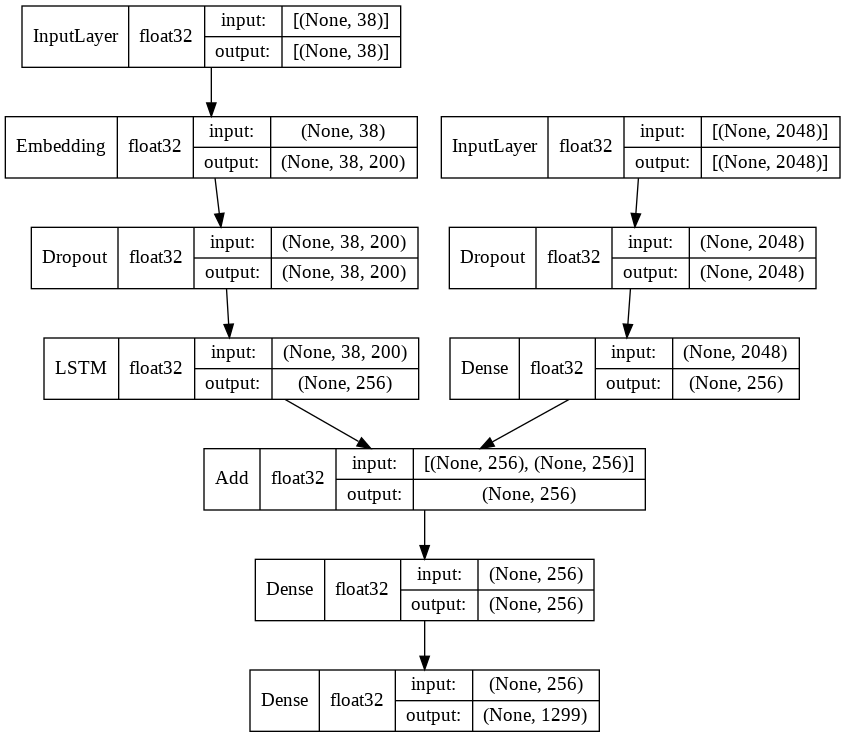

In [52]:
tf.keras.utils.plot_model(
    h_model,
    to_file="model.png",
    show_shapes = True,
    show_dtype = True,
    show_layer_names = False,
    rankdir = "TB",
    expand_nested = True,
    dpi=96,
)

#### Model summary to see exactly what its structure looks like in keras

In [53]:
h_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 38)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 38, 200)      259800      ['input_5[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

### Model Training
#### Before training the model
we need to do:
- include embedding matrix as weghits for **Embedding** layer in the model
- since we are using our own widgets from pre-trained Glove model we will freeze them, to ensure they will not change during the gradient descent process.

In [54]:
h_model.layers[2].set_weights([embedding_matrix])
h_model.layers[2].trainable = False

#### Compiling the model

In [55]:
h_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])   

#### Start Training

Start with **5** and **3** photo per batch. 

In [56]:
epochs = 20
number_pics_per_batch = 9
steps = len(all_train_val_captions) // number_pics_per_batch

In [ ]:
for i in range(epochs):
    generator = data_generator(caption_train_val, encoding_train_val, wordtoix, max_length, number_pics_per_batch)
    h_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    pickle_out = open("h_model.pkl", mode = "wb") 
    pickle.dump(h_model, pickle_out) 
    pickle_out.close()

2111/2111 [==============================] - 3101s 1s/step - loss: 3.2142 - accuracy: 0.3411


INFO:tensorflow:Assets written to: ram://4af48954-db8f-45d3-af28-1ff8c2953284/assets


INFO:tensorflow:Assets written to: ram://4af48954-db8f-45d3-af28-1ff8c2953284/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3450s 2s/step - loss: 2.5503 - accuracy: 0.4055


INFO:tensorflow:Assets written to: ram://40cce869-65c0-4f3a-b8a1-1167e978079e/assets


INFO:tensorflow:Assets written to: ram://40cce869-65c0-4f3a-b8a1-1167e978079e/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3479s 2s/step - loss: 2.3230 - accuracy: 0.4318


INFO:tensorflow:Assets written to: ram://72f9d646-e273-4e2f-8c1c-7f730956aeaa/assets


INFO:tensorflow:Assets written to: ram://72f9d646-e273-4e2f-8c1c-7f730956aeaa/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3420s 2s/step - loss: 2.1831 - accuracy: 0.4502


INFO:tensorflow:Assets written to: ram://05a2119a-880b-4771-a4e8-f62873b84880/assets


INFO:tensorflow:Assets written to: ram://05a2119a-880b-4771-a4e8-f62873b84880/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3461s 2s/step - loss: 2.0858 - accuracy: 0.4643


INFO:tensorflow:Assets written to: ram://56571a97-2edb-4dba-be9d-6d4979edd89a/assets


INFO:tensorflow:Assets written to: ram://56571a97-2edb-4dba-be9d-6d4979edd89a/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3247s 2s/step - loss: 2.0131 - accuracy: 0.4751


INFO:tensorflow:Assets written to: ram://86b6ef1f-8fee-4238-98fa-42965d0e3faa/assets


INFO:tensorflow:Assets written to: ram://86b6ef1f-8fee-4238-98fa-42965d0e3faa/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3295s 2s/step - loss: 1.9532 - accuracy: 0.4852


INFO:tensorflow:Assets written to: ram://2d7e8ed7-aafb-4507-9e59-d3970b4240e8/assets


INFO:tensorflow:Assets written to: ram://2d7e8ed7-aafb-4507-9e59-d3970b4240e8/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3491s 2s/step - loss: 1.9052 - accuracy: 0.4930


INFO:tensorflow:Assets written to: ram://a4457ee5-1cb1-4f94-81e1-04f4074f27f7/assets


INFO:tensorflow:Assets written to: ram://a4457ee5-1cb1-4f94-81e1-04f4074f27f7/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3355s 2s/step - loss: 1.8663 - accuracy: 0.4998


INFO:tensorflow:Assets written to: ram://c181d8e0-3484-41c2-9e2c-13e38197793d/assets


INFO:tensorflow:Assets written to: ram://c181d8e0-3484-41c2-9e2c-13e38197793d/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3391s 2s/step - loss: 1.8286 - accuracy: 0.5061


INFO:tensorflow:Assets written to: ram://09b55b08-33cf-41ac-a934-4247a65d6061/assets


INFO:tensorflow:Assets written to: ram://09b55b08-33cf-41ac-a934-4247a65d6061/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3370s 2s/step - loss: 1.7999 - accuracy: 0.5104


INFO:tensorflow:Assets written to: ram://322d14b3-29a2-46d4-9173-51a8b33c6b41/assets


INFO:tensorflow:Assets written to: ram://322d14b3-29a2-46d4-9173-51a8b33c6b41/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3307s 2s/step - loss: 1.7781 - accuracy: 0.5144


INFO:tensorflow:Assets written to: ram://38c63572-953f-491f-9cba-e20f54f2545f/assets


INFO:tensorflow:Assets written to: ram://38c63572-953f-491f-9cba-e20f54f2545f/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3383s 2s/step - loss: 1.7590 - accuracy: 0.5179


INFO:tensorflow:Assets written to: ram://233a23ea-ce44-4c31-a3f2-56ac505a98b8/assets


INFO:tensorflow:Assets written to: ram://233a23ea-ce44-4c31-a3f2-56ac505a98b8/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3371s 2s/step - loss: 1.7400 - accuracy: 0.5210


INFO:tensorflow:Assets written to: ram://3e026424-ad04-426f-bd89-5a5204289475/assets


INFO:tensorflow:Assets written to: ram://3e026424-ad04-426f-bd89-5a5204289475/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3369s 2s/step - loss: 1.7178 - accuracy: 0.5257


INFO:tensorflow:Assets written to: ram://cedfb5c2-67b3-45b6-ae33-88ceaaf08079/assets


INFO:tensorflow:Assets written to: ram://cedfb5c2-67b3-45b6-ae33-88ceaaf08079/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


2111/2111 [==============================] - 3148s 1s/step - loss: 1.6976 - accuracy: 0.5301


INFO:tensorflow:Assets written to: ram://2ce57e85-52d6-4645-998b-a27b00d2489a/assets


INFO:tensorflow:Assets written to: ram://2ce57e85-52d6-4645-998b-a27b00d2489a/assets
/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


  95/2111 [>.............................] - ETA: 51:39 - loss: 1.7145 - accuracy: 0.5245

change optimizer learning rate to **0.0001** and photo per batch to **6** with 10 epochs.

In [ ]:
h_model.optimizer.lr = 0.0001
epochs = 20
number_pics_per_batch = 6

NameError: ignored

In [ ]:
for i in range(epochs):
    generator = data_generator(caption_train_val, encoding_train_val, wordtoix, max_length, number_pics_per_batch)
    h_model.fit(generatbor, epochs = 1, steps_per_epoch = steps, verbose = 1 )
    pickle_out = open("h_model.pkl", mode = "wb") 
    pickle.dump(h_model, pickle_out) 
    pickle_out.close()

In [ ]:
for i in range(epochs):
    generator = data_generator(caption_train_val, encoding_train_val, wordtoix, max_length, number_pics_per_batch)
    h_model.fit(generator, epochs = 1, steps_per_epoch = steps, verbose = 1 )
    pickle_out = open("h_model.pkl", mode = "wb") 
    pickle.dump(h_model, pickle_out) 
    pickle_out.close()

NameError: ignored

### Covnert the final model into Tensorflow Lite
in order to use it in android application

In [ ]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(h_model)


converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]



tfmodel = converter.convert()
open('model.tflite', 'wb').write(tfmodel)

INFO:tensorflow:Assets written to: /tmp/tmpxznw21cp/assets


INFO:tensorflow:Assets written to: /tmp/tmpxznw21cp/assets


2148480

### Model Evaluation

In [ ]:
#generator = data_generator(caption_train_val, encoding_train_val, wordtoix, max_length, number_pics_per_batch)
#eval_dict = h_model.evaluate(x = generator, verbose = 1, return_dict = True)
#eval_dict

In [ ]:
import math
import re
from collections import Counter
WORD = re.compile(r"\w+")

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)



def get_avg_cosine(actuals, generated):
    sum_ = 0 
    for corpus in actuals:
        sum_ += get_cosine(corpus, generated)
    return sum_ / len(actuals)


def evaluate_model():
    sum_ = 0
    for i in encoding_test.keys():
        
        generated_caption_ = greedySearch(encoding_test[i].reshape((1,2048)))
        generated_caption = text_to_vector(generated_caption_)
        actual_captions = [text_to_vector(caption_test['Caption_1'][i]),\
                           text_to_vector(caption_test['Caption_2'][i]),\
                           text_to_vector(caption_test['Caption_3'][i]),\
                           text_to_vector(caption_test['Caption_4'][i]),\
                           text_to_vector(caption_test['Caption_5'][i])]
        sum_ += get_avg_cosine(actual_captions, generated_caption)
        print(get_avg_cosine(actual_captions, generated_caption))
        print(actual_captions,'==>', generated_caption)
        break
    return sum_ / len(encoding_test.keys())
evaluate_model()

0.0
[Counter({'the': 7, 'of': 3, 'startseq': 1, 'process': 1, 'washing': 1, 'saee': 1, 'tawaf': 1, 'roof': 1, 'and': 1, 'rest': 1, 'corridors': 1, 'grand': 1, 'mosque': 1, 'endseq': 1}), Counter({'the': 7, 'of': 3, 'startseq': 1, 'process': 1, 'washing': 1, 'saee': 1, 'tawaf': 1, 'roof': 1, 'and': 1, 'rest': 1, 'corridors': 1, 'grand': 1, 'mosque': 1, 'endseq': 1}), Counter({'the': 7, 'of': 3, 'startseq': 1, 'process': 1, 'washing': 1, 'saee': 1, 'tawaf': 1, 'roof': 1, 'and': 1, 'rest': 1, 'corridors': 1, 'grand': 1, 'mosque': 1, 'endseq': 1}), Counter({'the': 7, 'of': 3, 'startseq': 1, 'process': 1, 'washing': 1, 'saee': 1, 'tawaf': 1, 'roof': 1, 'and': 1, 'rest': 1, 'corridors': 1, 'grand': 1, 'mosque': 1, 'endseq': 1}), Counter({'the': 7, 'of': 3, 'startseq': 1, 'process': 1, 'washing': 1, 'saee': 1, 'tawaf': 1, 'roof': 1, 'and': 1, 'rest': 1, 'corridors': 1, 'grand': 1, 'mosque': 1, 'endseq': 1})] ==> Counter({'a': 4, 'man': 1, 'in': 1, 'red': 1, 'jacket': 1, 'is': 1, 'pointing': 1

0.0

### Model Testing 

In [1]:
for z in range(len(encoding_test.keys())):
    print('Pic In ==>', z)
    pic = list(encoding_test.keys())[z]
    image_ = encoding_test[pic].reshape((1,2048))
    x=plt.imread(image_path+'/'+pic)
    plt.imshow(x)
    plt.show()
    print("Caption:",greedySearch(image_))

NameError: ignored

### Best Result

In [ ]:
best_result = [0,42,18,20,21,35,37,46,50]
img_paths = []
for i in best_result:
    pic = list(encoding_test.keys())[i]
    img_paths.append(image_path+pic)


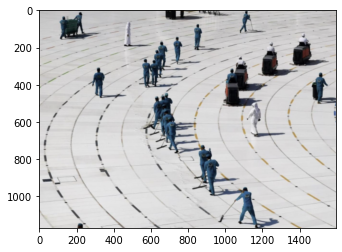

/content/drive/MyDrive/photosof_dataset/997722105_0me5439477.jpg
الوصف: رجل يرتدي سترة حمراء يشير إلى جسر


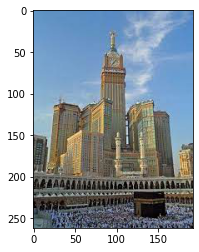

/content/drive/MyDrive/photosof_dataset/997722104_0me5439476.jpg
الوصف: يقف رجل بجانب نار كبيرة


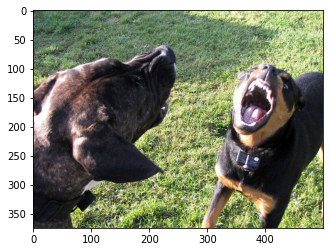

/content/drive/MyDrive/photosof_dataset/3542341321_faa2d2d48a.jpg
الوصف: كلب بني يتدحرج في العشب


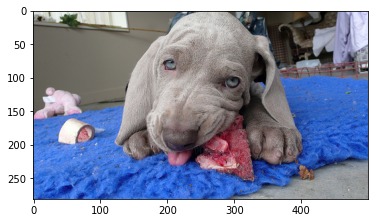

/content/drive/MyDrive/photosof_dataset/2655196158_5c878a4af0.jpg
الوصف: كلب بني يجري في نفق أخضر


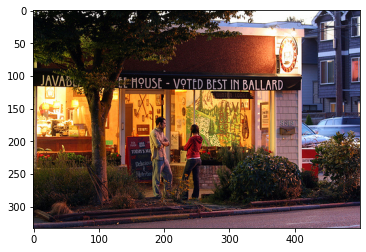

/content/drive/MyDrive/photosof_dataset/1370773415_967b1ffde1.jpg
الوصف: مجموعة من الناس تقف أمام البنك


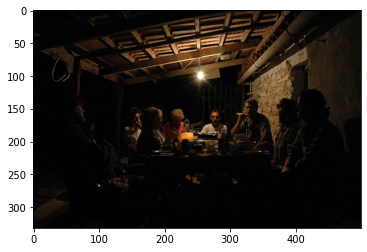

/content/drive/MyDrive/photosof_dataset/107582366_d86f2d3347.jpg
الوصف: رجل يرتدي بدلة وامرأة في قميص أبيض يجلسان في متجر


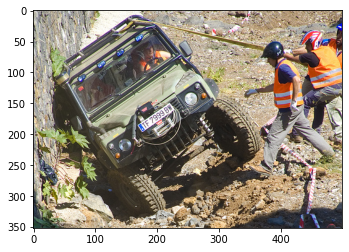

/content/drive/MyDrive/photosof_dataset/1466307489_cb8a74de09.jpg
الوصف: رجل يركب دراجة ترابية خضراء عبر الغابة


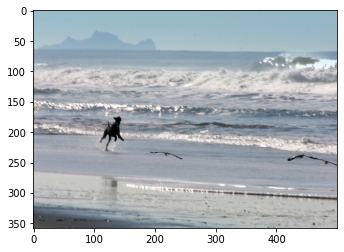

/content/drive/MyDrive/photosof_dataset/339350939_6643bfb270.jpg
الوصف: رجل يقف على الشاطئ بجانب الشاطئ


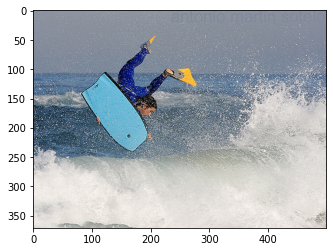

/content/drive/MyDrive/photosof_dataset/3293642024_e136b74a55.jpg
الوصف: راكب أمواج يركب موجة


In [ ]:
for path in img_paths:
    result, tmp = ar_caption(path)
    print(path)
    print(result)

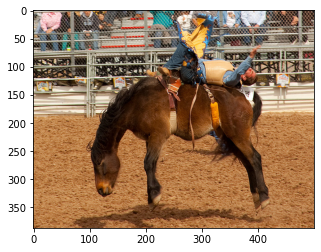

Caption: a man in a white shirt is riding a bucking horse


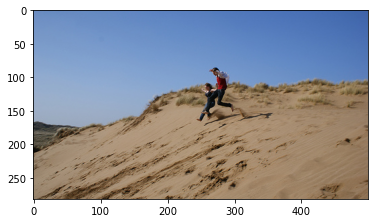

Caption: a man in a black shirt and jeans is walking on a hill


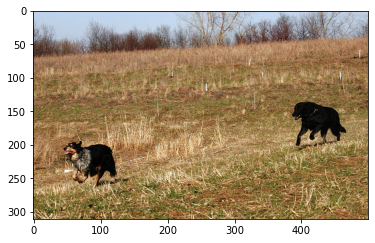

Caption: two dogs run through the grass


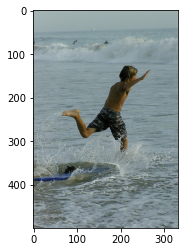

Caption: a man in swimming trunks is jumping into the ocean


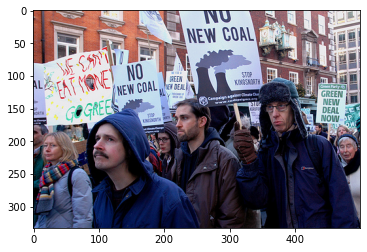

Caption: a woman in a black coat and a man in a black jacket are facing the crowd


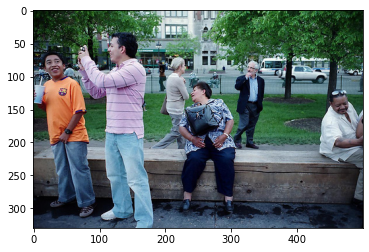

Caption: a group of people are standing around a building


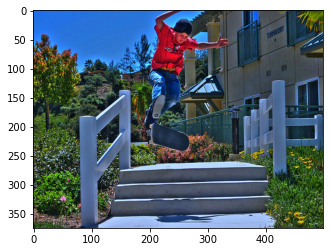

Caption: a skateboarder is skating on a rail


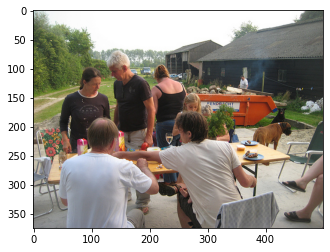

Caption: a group of people are standing around a table


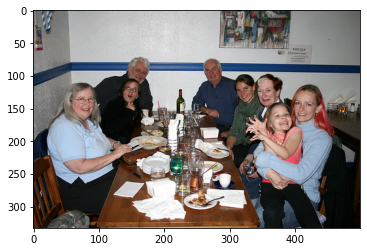

Caption: a group of people are sitting at a table eating food


In [ ]:
for path in img_paths:
    result, tmp = en_caption(path)
    print(result)

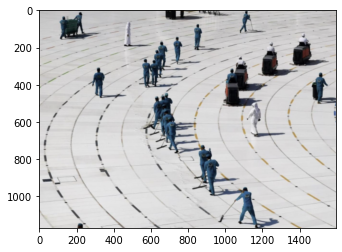

Caption: a man in a red jacket is pointing a against a bridge


error: ignored

In [ ]:
en_speech(img_paths[0])

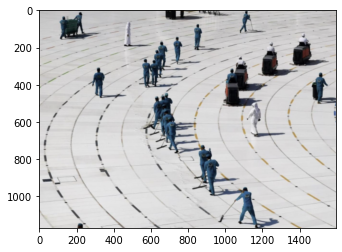

الوصف: رجل يرتدي سترة حمراء يشير إلى جسر


error: ignored

In [ ]:
ar_speech(img_paths[0])